In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import matplotlib as mpl
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
from utils import u_statistics as u_stats
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats, ndimage
import warnings
from scipy.ndimage.measurements import label
import shapely.geometry as shpg
import matplotlib.patches as mpatches
import datetime
import pickle as pkl
import glob

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [4]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_3dRolling_SouthAmerica_1985-2018_diffs.nc')
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_all = corr_all.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [5]:
def readERA(var):

    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981*_peru_big.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [6]:
era = readERA('u200')
era = era.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [7]:
# eraq = readERA('q550')
# eraq = eraq.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [8]:
# erau = readERA('u550')
# erau = erau.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [9]:
erav5 = readERA('v250')
erav5 = erav5.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()
erau5 = readERA('u250')
erau5 = erau5.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

In [10]:
m1=9
m2=4

In [12]:
era_BH_base = era['u'].sel(time=((era['time.year']>=1985)&(era['time.year']<=2018))).load()
era_BH = era_BH_base.groupby('time.month').mean('time')
era_BH_doy = era_BH_base.groupby('time.dayofyear').mean('time') # average day of year

In [13]:
era_z = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/qr_15UTC/uv_15UTC_*_peru2.nc')
era_z = uda.flip_lat(era_z)
era_z = era_z.sel(latitude=slice(-25,0), longitude=slice(-81,-45), time=((era_z['time.year']>=2005)&(era_z['time.year']<=2018))).load()
era_z_month = era_z.groupby('time.month').mean('time')

In [14]:
# era_BH_u550_base = erau['u550'].sel(time=((erau['time.year']>=1985)&(erau['time.year']<=2018))).load()
# era_BH_u550 = era_BH_u550_base.groupby('time.month').mean('time')
# era_BH_doy_u550 = era_BH_u550_base.groupby('time.dayofyear').mean('time')

In [15]:
# era_BH_q550_base = eraq['q550'].sel(time=((eraq['time.year']>=1985)&(eraq['time.year']<=2018))).load()
# era_BH_q550 = era_BH_q550_base.groupby('time.month').mean('time')
# era_BH_doy_q550 = era_BH_q550_base.groupby('time.dayofyear').mean('time')

In [16]:
era_BH_u250_base = erau5['u'].sel(time=((erau5['time.year']>=1985)&(erau5['time.year']<=2018)))
era_BH_u250 = era_BH_u250_base.groupby('time.month').mean('time')
era_BH_v250_base = erav5['v'].sel(time=((erav5['time.year']>=1985)&(erav5['time.year']<=2018)))
era_BH_v250 = era_BH_v250_base.groupby('time.month').mean('time')

In [17]:
ws = np.sqrt(era_BH_u250**2 + era_BH_v250**2)

In [18]:
ws

<xarray.DataArray (month: 12, latitude: 101, longitude: 93)>
array([[[16.800821 , 16.870773 , 16.945366 , ..., 13.155425 ,
         13.138842 , 13.12443  ],
        [16.5101   , 16.578873 , 16.651007 , ..., 12.622276 ,
         12.596545 , 12.578988 ],
        [16.225397 , 16.289371 , 16.356113 , ..., 12.060564 ,
         12.031799 , 12.014354 ],
        ...,
        [ 2.9710174,  2.872231 ,  2.7841098, ...,  5.8849072,
          5.878773 ,  5.8718843],
        [ 3.099414 ,  2.993487 ,  2.9194984, ...,  5.861434 ,
          5.870466 ,  5.8658624],
        [ 3.225404 ,  3.1041272,  3.0346575, ...,  5.8484764,
          5.8612866,  5.864112 ]],

       [[17.360657 , 17.417011 , 17.469805 , ..., 13.939831 ,
         13.866551 , 13.809849 ],
        [17.06537  , 17.12067  , 17.173218 , ..., 13.4741745,
         13.403018 , 13.35475  ],
        [16.774122 , 16.825428 , 16.875498 , ..., 12.997116 ,
         12.935546 , 12.894829 ],
...
        [ 3.1095169,  3.190245 ,  3.2660673, ...,  2.737867 ,
          2.7503762,  2.7560654],
        [ 3.2357802,  3.3329391,  3.4163134, ...,  2.7284105,
          2.7422569,  2.7366757],
        [ 3.372917 ,  3.4812427,  3.5505316, ...,  2.7142289,
          2.734286 ,  2.7333581]],

       [[21.065462 , 21.171524 , 21.276499 , ..., 18.908247 ,
         18.861862 , 18.803522 ],
        [20.853294 , 20.95922  , 21.061678 , ..., 18.330317 ,
         18.28106  , 18.223326 ],
        [20.629524 , 20.73254  , 20.83088  , ..., 17.727724 ,
         17.683956 , 17.62775  ],
        ...,
        [ 3.502723 ,  3.427769 ,  3.3757715, ...,  5.1520853,
          5.142118 ,  5.1265507],
        [ 3.6059673,  3.529535 ,  3.4903312, ...,  5.1188045,
          5.1105347,  5.084606 ],
        [ 3.706129 ,  3.6237822,  3.5806947, ...,  5.0800557,
          5.063899 ,  5.0348043]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
    level      int32 250
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [ ]:
import cartopy.feature as cf
f = plt.figure(figsize=(13,8), dpi=200)
bhlat = []
for mm in range(1,13):

    mapsdryu2 = era_z_month['u'].sel(month=mm)
    mapsdryv2 = era_z_month['v'].sel(month=mm)
#     mapsdryu2 = era_BH_u250.sel(month=mm)
#     mapsdryv2 = era_BH_v250.sel(month=mm)
    wsm = ws.sel(month=mm, longitude=slice(-78,-55))
    
    #gpot = era_z_month.sel(month=mm)['z']/1000

    ax = f.add_subplot(3,4,mm, projection=ccrs.PlateCarree())

    uanodry = mapsdryu2
    vanodry = mapsdryv2 # multiplied by 10 since vertical component is very small compared to horizontal one

    st=3
    sarrow = 1
    xquiv = mapsdryu2.longitude[sarrow::st]
    yquiv = mapsdryu2.latitude[sarrow::st]

    uud = (uanodry)[sarrow::st, sarrow::st]  
    vvd = (vanodry)[sarrow::st, sarrow::st]

    ax.coastlines()
    ax.add_feature(cf.BORDERS)
            # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    
#     gpos = np.max(gpot.values)
#     print(gpos)
   
    # glat = era_z_month.latitude.values[gpos[1]]
    # glon = era_z_month.longitude.values[gpos[0]]
    
    wsmin = np.unravel_index(np.argmin(wsm.values), wsm.values.shape)
    wlat = era_z_month.latitude.values[wsmin[0]]
    
    print('lat', wlat)
    bhlat.append(wlat)
    
    plt.contourf(mapsdryu2.longitude, mapsdryu2.latitude, mapsdryu2, levels=np.arange(-8,8.02,1), cmap='RdBu_r', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar(label='m s$^{-1}$')
    
    #plt.contour(mapsdryu2.longitude, mapsdryu2.latitude, gpot, colors='k', levels=[gpos-0.05, gpos-0.025, gpos-0.01, gpos+1],transform=ccrs.PlateCarree())
    
    plt.contour(wsm.longitude, wsm.latitude, wsm, colors='r', levels=[-0.2,0,0.3],transform=ccrs.PlateCarree(), linewidths=3)
    #print(gpos, glat, glon)
    #ipdb.set_trace()
    #ax.scatter(gpos[0], gpos[1], color='k')
    
    #plt.contour(height.longitude, height.latitude, height['h'], levels=[1000,2000])
    #plt.quiver(xquiv, yquiv, uud, vvd, scale=55, width=0.002, headwidth=7)
    
    ax.streamplot(mapsdryu2.longitude,mapsdryu2.latitude, uanodry.values, vanodry.values, density=[0.5, 1], color='k', linewidth=0.5)
    
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title('Month: '+str(mm))

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/supp_BHcirc_stream.jpg')

lat -17.75
lat -17.5
lat -15.25
lat -10.75
lat -4.75


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


lat -4.25


/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


lat -3.25


In [ ]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [ ]:
def find_doy(corr_all, gt_doy=None, lt_doy=None):
    
    if gt_doy is not None:
        mask = corr_all.dayofyear>gt_doy
        pindex = 0
        rcheck = -60  #-60
    if lt_doy is not None:
        mask = corr_all.dayofyear<lt_doy
        pindex = -1
        rcheck = 60 #60
        
    corr = corr_all.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r'].values

    thresh = 0.1
    array[array <= thresh] = 0  # T threshold maskout
    array[np.isnan(array)] = 0  # set ocean nans to 0
    outarr_3 = np.zeros((array.shape[1], array.shape[2]))
    outarr_5 = np.zeros((array.shape[1], array.shape[2]))
    outarr_max = np.zeros((array.shape[1], array.shape[2]))

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            
            ts = array[:,y,x]
            labels, numL = label(ts)

            u, inv = np.unique(labels, return_inverse=True)
            n = np.bincount(inv)

            inds_3 = u[(n>=3)&(u!=0)] ## min 3 days onset
            inds_5 = u[(n>=5)&(u!=0)] ## min 5 days breakdown
            

            if len(inds_3)>0:
                pos3 = np.where(labels==inds_3[pindex])
                day3 = ((corr_sig.dayofyear.values+1)[(pos3[0])[pindex]])
            else:
                day3 = np.nan

            if len(inds_5)>0:
                pos5 = np.where(labels==inds_5[pindex])
                day5 = ((corr_sig.dayofyear.values+1)[pos5[0][pindex]])
            else:
                day5 = np.nan

            if (pindex==0) & (np.sum(array[rcheck::,y,x]==0)/abs(rcheck)>0.85):  # remove pixels where more than 40 days in Nov/Dev have no correlation
                day3 = np.nan
                day5 = np.nan
            if (pindex==-1) & (np.sum(array[::rcheck,y,x]==0)/abs(rcheck)>0.85): # remove pixels where more than 40 days in Jan/Feb have no correlation
                day3 = np.nan
                day5 = np.nan

            outarr_3[y,x] = day3
            outarr_5[y,x] = day5
            outarr_max[y,x] = (corr_sig.dayofyear.values+1)[np.argmax(ts)]
            
    outarr_3 = xr.DataArray(outarr_3, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
    outarr_5 = xr.DataArray(outarr_5, coords=[corr['latitude'], corr['longitude']], dims=[ 'latitude','longitude'])
            
#     grid = corr.salem.grid.regrid(factor=1)
#     #ipdb.set_trace()
#     outarr_3 = grid.lookup_transform(outarr_3)
#     outarr_5 = grid.lookup_transform(outarr_5)
#     grid = grid.to_dataset()
#     outarr_3 = xr.DataArray(outarr_3, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])
#     outarr_5 = xr.DataArray(outarr_5, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])

    return outarr_3, outarr_5

In [ ]:
def find_doy_max(corr_all, start, end):

# 

        
    corr = corr_all#.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r']

    thresh = 0.1
    array.values[array.values <= thresh] = 0  # T threshold maskout
    array.values[np.isnan(array.values)] = 0  # set ocean nans to 0
    
    outarr_max = np.zeros((array.shape[1], array.shape[2]))*np.nan
    corr_max = np.zeros((array.shape[1], array.shape[2]))*np.nan
    

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            #ipdb.set_trace()
            ts = array.isel(longitude=x, latitude=y)
            starts = start.values[y,x]
            ends = end.values[y,x]
            
            if np.isnan(starts) | np.isnan(ends):
                continue
            
            #ipdb.set_trace()
            valmax = ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends))).rolling(dayofyear=5, min_periods=3, center=True).mean().argmax()
            #ipdb.set_trace()
            doys = (ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends))).dayofyear.values+1)[valmax]
            month = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(doys - 1)+' days')
            outarr_max[y,x] = month.month
            corr_max[y,x] = ts.isel(dayofyear=((ts.dayofyear>starts) | (ts.dayofyear<ends)))[valmax]
            
    out_max = xr.DataArray(outarr_max, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
    corr_out_max = xr.DataArray(corr_max, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])

    return out_max, corr_out_max

In [ ]:
outarr_3, outarr_5 = find_doy(corr_all, gt_doy=213)  # doy 182 is 1st July
endarr_3, endarr_5= find_doy(corr_all, lt_doy=213)

o3 = outarr_3.values.copy()
e5 = endarr_5.values.copy()

# o3[topo_on_g<300]=np.nan
# e5[topo_on_g<300]=np.nan
start=np.nanmedian(o3, axis=1)
end = np.nanmedian(e5, axis=1)

In [23]:
corrdic = {'start_3d' : outarr_3, 'end_5d' : endarr_5}
pkl.dump(corrdic, open(cnst.network_data + 'data/HUARAZ/saves/corr_GRIDSAT-15_start_end.p',
                               'wb'))

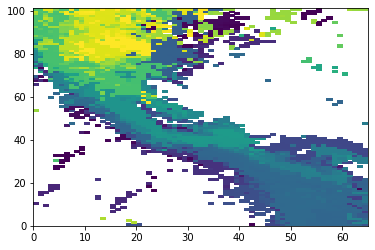

In [24]:
plt.pcolormesh(e5)

In [25]:
outmax_gt, corrmax = find_doy_max(corr_all, outarr_3, endarr_5)

In [26]:
ch_on_era = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')
chirps_doypick = ch_on_era['precip'].sel(time=((ch_on_era['time.year']>=1985)&(ch_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))
chirps_bimod = chirps_doypick#.rolling(time=30, min_periods=3, center=True).mean()#.where((chirps_doypick['time.month']!=8))

In [27]:
tir_on_era = xr.open_mfdataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/daily_-15ALLkm2_UTC_DAY_onBIGERA/*.nc',
                                combine='nested', concat_dim='time')
tir_doypick = tir_on_era['tir'].sel(time=((tir_on_era['time.year']>=1985)&(tir_on_era['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [28]:
tir_on_era

<xarray.Dataset>
Dimensions:    (latitude: 125, longitude: 97, time: 12908)
Coordinates:
  * time       (time) datetime64[ns] 1984-01-01 1984-01-02 ... 2019-09-30
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
Data variables:
    tir        (time, latitude, longitude) float64 dask.array<chunksize=(31, 125, 97), meta=np.ndarray>
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [29]:
ch_doy=chirps_bimod.groupby('time.month').mean().load()#.rolling(dayofyear=30, min_periods=3, center=True).mean()
ch_doy_lonmean = ch_doy.where(topo_on_g>=2000).mean('longitude')/ch_doy.where(topo_on_g>=2000).mean('longitude').sum('month') # monthly relative to annual per latitude
basis = ch_doy.where(topo_on_g>=2000).mean('longitude').sum('month')
ch_doy_lonmean = ch_doy_lonmean.rolling(latitude=10, min_periods=1, center=True).mean().where(basis>15, other=0)#.argmax('latitude')
maxpos = ch_doy_lonmean.argmax('latitude') # latitude with maximum relative rainfall

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [30]:
# ch_doy=chirps_bimod.rolling(time=30, min_periods=3, center=True).mean().groupby('time.dayofyear').mean()
# ch_doy_lonmean = ch_doy.where(topo_on_g>=2000).mean('longitude')/ch_doy.where(topo_on_g>=2000).mean('longitude').sum('dayofyear')
# basis = ch_doy.where(topo_on_g>=2000).mean('longitude').sum('dayofyear')
# ch_doy_lonmean = ch_doy_lonmean.rolling(latitude=10, min_periods=1, center=True).mean().where(basis>15, other=0)#.argmax('latitude')
# maxpos = ch_doy_lonmean.argmax('latitude')
# ch_doy = ch_doy.load()

In [31]:
maxpos.values

array([ 30,  30,  68,  80, 100,  94,  97,  97, 100,  74,  67,  30])

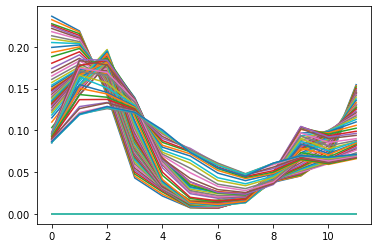

In [32]:
plt.plot(ch_doy_lonmean)

In [33]:
def loc_minmax(ts):
            
    out = np.where(ts == ndimage.maximum_filter(ts, (50,), mode='constant', cval=np.amax(ts) + 1))

    return out[0]

In [34]:
ch_doyy=chirps_bimod.groupby('time.dayofyear').mean().load().where(topo_on_g>=2000).mean('longitude')   #.load().rolling(dayofyear=10, min_periods=3, center=True).mean()

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


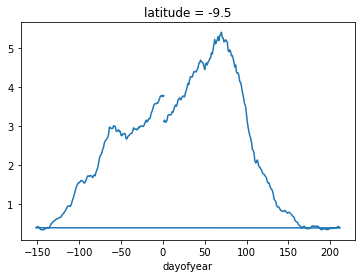

In [35]:
ch_doyy.dayofyear.values[ch_doyy.dayofyear.values>=213] = (ch_doyy.dayofyear.values[ch_doyy.dayofyear.values>=213])-365
ch_doyy.rolling(dayofyear=20, min_periods=3, center=True).mean().sel(latitude=-9.5).plot()

In [36]:
loc_minmax(ch_doyy.sel(latitude=-7).rolling(dayofyear=50, min_periods=3, center=True).mean())   #.rolling(dayofyear=20, min_periods=3, center=True).mean()

array([ 74, 316])

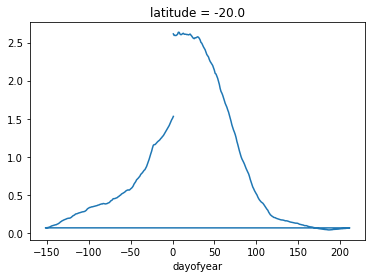

In [37]:
ch_doyy.rolling(dayofyear=50, min_periods=3, center=True).mean().sel(latitude=-20).plot()

In [38]:
isdiurn = ch_doyy.rolling(dayofyear=50, min_periods=3, center=True).mean()
bimod = []
for isd in isdiurn.latitude:
    ts = isdiurn.sel(latitude=isd)
    num = len(loc_minmax(ts))
    bimod.append(num)

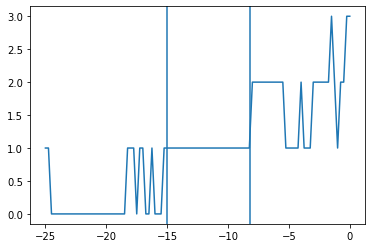

In [39]:
plt.plot(isdiurn.latitude,bimod)
plt.axvline(-8.2)
plt.axvline(-15)

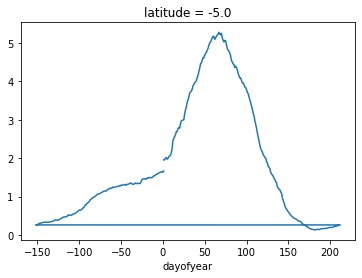

In [40]:
ch_doyy.rolling(dayofyear=50, min_periods=3, center=True).mean().sel(latitude=-5).plot()

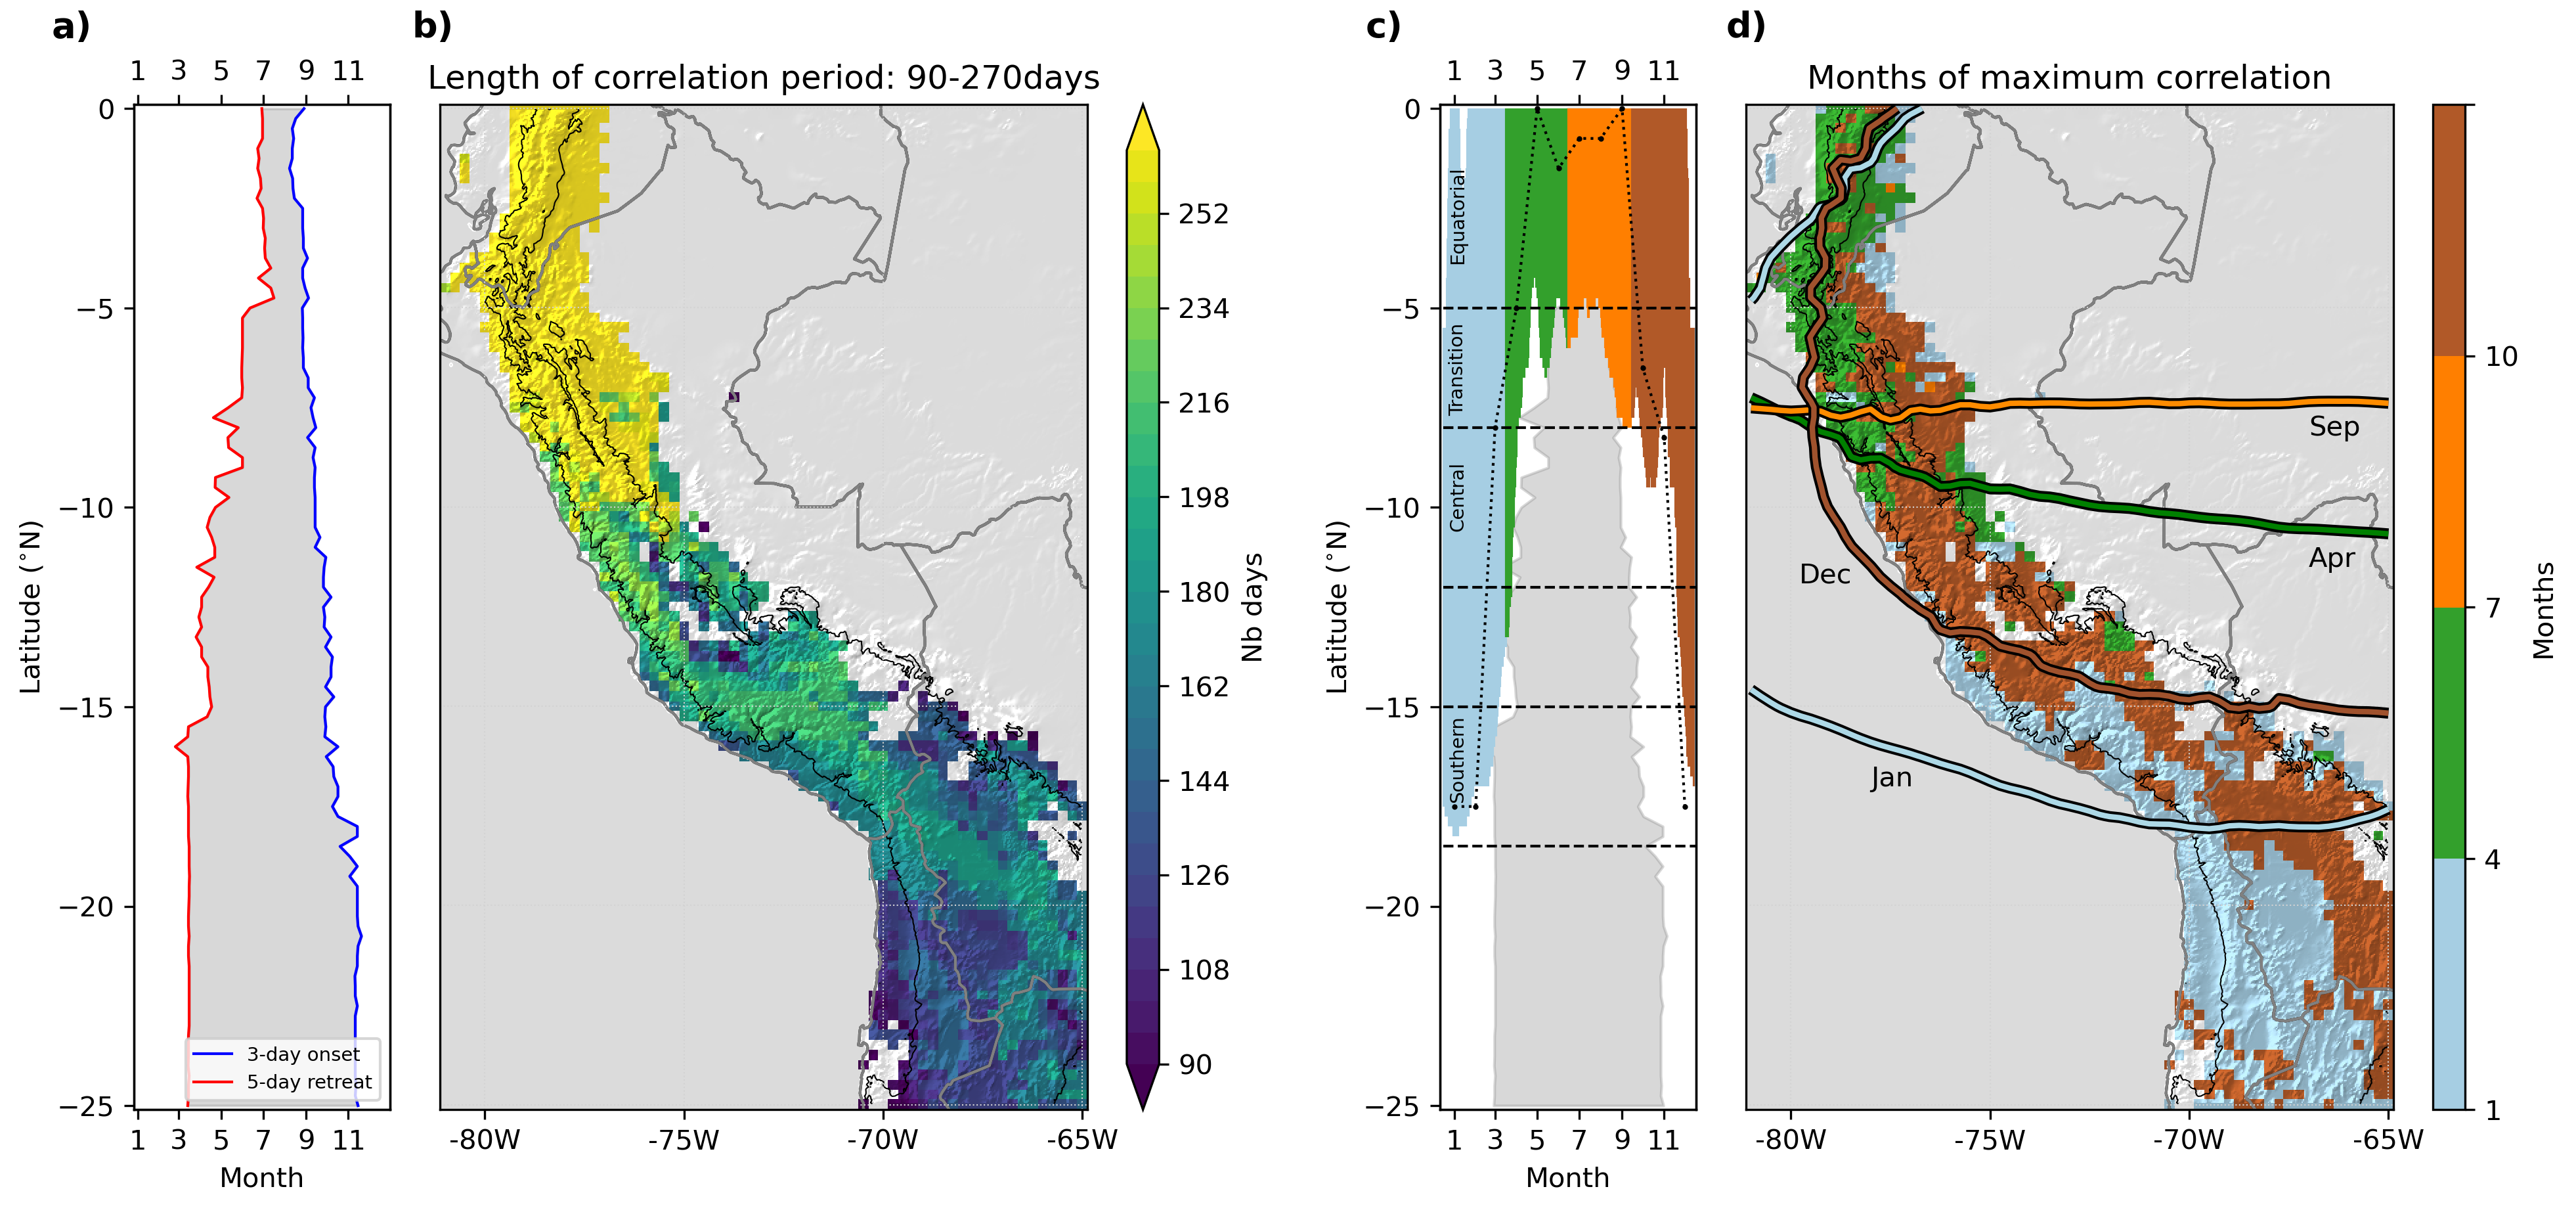

In [49]:
###### lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'), cached=True)

map = corr_all.salem.get_map()
map.set_shapefile(countries=True, color='grey', linewidths=1)
# Change the lon-lat countour setting
map.set_lonlat_contours(add_ytick_labels=False, interval=5, linewidths=0.5,
                         linestyles='dotted', colors='lightgrey')

#fpath = salem.get_demo_file('hef_srtm.tif')
map.set_topography(topo, relief_factor=1.4)


f = plt.figure(figsize=(13,6), dpi=300)

left, width, width2 = 0.045, 0.4, 0.10#0.345
space=0.003
left2 = left + width + width2 +0.01

bottom, height = 0.07, 0.85


map1 = [left+width2-0.04, bottom, width, height]
line1 = [left, bottom, width2, height]

map2 = [left2+width2-0.04, bottom, width, height]
line2 = [left2, bottom, width2, height]

ax = plt.axes(map1)
endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
season = (365-outarr_3)+endarr_5
map.set_data(season)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both') #np.arange(90,270,6)
map.set_contour(topo, interp='linear', levels=[0, 2000], cmap='Greys', linewidths=0.5)
map.visualize(cbar_title='Nb days', title='Length of correlation period: 90-270days', orientation='vertical')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax2 = plt.axes(line1)

ax2.plot(start,corr_all.latitude.values, color='b', label='3-day onset', linewidth=1)
ax2.plot(end ,corr_all.latitude.values, color='r', label='5-day retreat', linewidth=1)
plt.legend(loc='lower right', fontsize=7)
mmdays = [1,32,60,91,121,152,182,213,244,274,305,335]
#mmdays = list(np.array([1,32,60,91,121,152,182])+213)+list(np.array([213,244,274,305,335])-213)
mdays = [1,60,121,182,244,305]
ax2.set_xticks(mdays)
ax2.set_xticklabels(np.arange(1,13,2))
ax2.set_ylim(-25.1,0.1)
ax2.set_xlim(-5,365)
ax2.fill_betweenx(corr_all.latitude.values,end,start, color='grey', alpha=0.3)
ax2.set_xlabel('Month')
ax2.set_ylabel('Latitude ($^{\circ}$N)')
ax22 = ax2.twiny()
ax22.set_xticks(mdays)
ax22.set_xticklabels(np.arange(1,13,2))
ax22.set_ylim(-25.1,0.1)
ax22.set_xlim(-5,365)


ax4 = plt.axes(map2)
import seaborn as sns
colord = sns.color_palette("Paired",as_cmap=True)
colore = sns.color_palette("Paired")


season = outmax_gt

season.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
#season = (365-outarr_3)+endarr_5
map.set_data(season)
map.set_plot_params(levels=[1,4,7,10,13], cmap=colord) #np.arange(90,270,6)  [1,3,5,7,9,11,13]
map.set_contour(topo, interp='linear', levels=[0, 2000], cmap='Greys', linewidths=0.5)

map.set_text(-78, -17, 'Jan', fontsize=10)
map.set_text(-79.8, -11.9, 'Dec', fontsize=10)
map.set_text(-67, -11.5, 'Apr', fontsize=10)
map.set_text(-67, -8.2, 'Sep', fontsize=10)

# coord = [-0.5, 0.5, -26, -60]
# geom = shpg.box(coord[0], coord[2], coord[1], coord[3])
# map.set_geometry(geom, zorder=99, color='white', linewidth=3, linestyle='--')

cb = map.visualize(cbar_title='Months', title='Months of maximum correlation', orientation='vertical')

# tbox = [-3,0,-65,-60]
# ax4.add_patch(mpatches.Rectangle(xy=[tbox[0], tbox[2]], width=tbox[1]-tbox[0], height=tbox[3]-tbox[2], facecolor='white', alpha=1, zorder=99)) #, transform=ccrs.PlateCarree()

f.patches.extend([plt.Rectangle((0.963,0.9),0.02,0.035,
                                  fill=True, color='white', alpha=1, zorder=1000,
                                  transform=f.transFigure, figure=f)])

plt.plot(-77.5, -9.5, 'ro', markersize=5)

ccolors = ['lightblue','lightblue', 'lightblue', 'g','g', 'g', 'darkorange', 'darkorange','darkorange', 'sienna', 'sienna', 'sienna']

#ccolors = ['b','b', 'b', 'g','g', 'g', 'y', 'y','y', 'r', 'r', 'r']
xo, yo = map.grid.transform(era_BH.longitude.values, era_BH.latitude.values,
                                    crs=era_BH.salem.grid.proj)
for ids, eb in enumerate(era_BH):
    #print(ids)
    if ids+1 not in np.array([1,4,9,12]):   #,4,6,7,9,10
        continue
    #print(ids, colord[ids])
    ax4.contour(xo,yo,eb.values, levels=[0], colors='k', linewidths=4)
    ax4.contour(xo,yo,eb.values, levels=[0], colors=ccolors[ids],linewidths=2)
    
# ax4.text(-78,-17,'Jan', fontsize=7, family='sans-serif')

    
    
ax5 = plt.axes(line2)
mdays = np.array([1,32,60,91,121,152,182,213,244,274,305,335])+15
ccinds = {1:0,2:0,3:0,4:3,5:3,6:3,7:7,8:7,9:7,10:11,11:11,12:11}
for ids, eb in enumerate(era_BH_doy.rolling(dayofyear=15, min_periods=3, center=True).mean()):
    #print(ids)
    #print(ids, colord[ids])
    #ipdb.set_trace()
    date = datetime.datetime(2017, 1, 1) + pd.Timedelta(str(eb.dayofyear.values - 1)+' days')
    #ipdb.set_trace()
    cinds=ccinds[date.month]
    eis = eb.where((topo_on_g>2000)&(eb<0)).mean('longitude')
    lats = eb.latitude[np.isfinite(eis)]
    ax5.vlines(ids+1,np.min(lats),np.max(lats),lw=1, color=colore[cinds]) #mdays[ids]
    #ipdb.set_trace()

csfont = {'fontname':'DejaVu Sans'}
ax5.text(8,-7.6,'Transition', fontsize=7, family='sans-serif', rotation=90)
ax5.hlines(-8,0,365, color='k', linestyle='dashed', linewidth=1)
ax5.text(8,-3.8,'Equatorial', fontsize=7, rotation=90)
ax5.hlines(-5,0,365, color='k', linestyle='dashed', linewidth=1)

ax5.text(8,-10.5,'Central', fontsize=7, rotation=90)
ax5.hlines(-12,0,365, color='k', linestyle='dashed', linewidth=1)
ax5.text(8,-17.3,'Southern', fontsize=7, rotation=90) # -19.7
ax5.hlines(-15,0,365, color='k', linestyle='dashed', linewidth=1)
ax5.hlines(-18.5,0,365, color='k', linestyle='dashed', linewidth=1)

#mdays = np.arange(1,367)
ax5.plot(mdays, eb['latitude'].values[maxpos.values], color='k', linestyle='dotted', zorder=98, linewidth=1, marker='o', markersize=1) # maxpos rain
#ax5.plot(mdays, bhlat, color='k', marker='o', markersize=2, linewidth=0.5, zorder=99)

#ax5.fill_betweenx(corr_all.latitude.values,121+15,274+15, color='grey', alpha=0.3, ec='white')
ax5.fill_betweenx(corr_all.latitude.values,end,start, color='grey', alpha=0.3)
# for llat in ch_doy_lonmean.latitude:
#     mpos = loc_minmax(ch_doy_lonmean.sel(latitude=llat).values)
#     for mp in mpos:
#         plt.plot(mp,llat, color='k', marker='o', markersize=1)




mdays = np.array([1,60,121,182,244,305])+15
ax5.set_xticks(mdays)
ax5.set_xticklabels(np.arange(1,13,2))
ax5.set_ylim(-25.1,0.1)
ax5.set_xlim(-5,366)
#ax5.fill_betweenx(corr_all.latitude.values,end,start, color='grey', alpha=0.3)
ax5.set_xlabel('Month')
ax5.set_ylabel('Latitude ($^{\circ}$N)')
ax55 = ax5.twiny()
ax55.set_xticks(mdays)
ax55.set_xticklabels(np.arange(1,13,2))
ax55.set_ylim(-25.1,0.1)
ax55.set_xlim(-5,366)

plt.annotate('a)', xy=(0.02, 0.96), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('b)', xy=(0.16, 0.96), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('c)', xy=(0.53, 0.96), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')
plt.annotate('d)', xy=(0.67, 0.96), xytext=(0, 4), size=13, xycoords=('figure fraction', 'figure fraction'),
                 textcoords='offset points', fontweight='bold')

#plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/seasonal.jpg')

In [43]:
u2 = era.sel(time=((era['time.year']>=1985)&(era['time.year']<=2018))).where(topo_on_g>=2000)

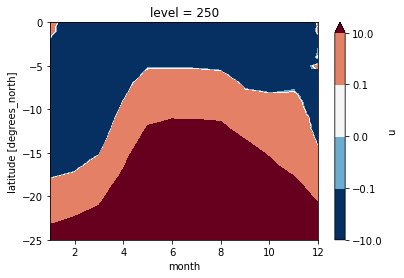

In [44]:
u2['u'].groupby('time.month').mean().mean('longitude').T.plot.contourf(levels=[-10,-0.1,0,0.1,10])
#u2['u'].groupby('time.month').mean().mean('longitude').T.plot.contour(levels=[-10,-5,-2,-1,0,1,2,5,10])

In [45]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

In [46]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}
def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

In [47]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray of season/year groups
#     year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
#                                coords=[ds.time], name='year_season')

    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),coords=[ds.time],name='month_length')
    result = ((ds * month_length).resample(time='QS-DEC').sum() /  month_length.where(ds.notnull()).resample(time='QS-DEC').sum())
    #ipdb.set_trace()
    # Calculate the weighted average
    return result[result['time.month']==12]

In [68]:
era_djf = season_mean(u2['u'])

In [69]:
ch_djf = season_mean(chirps_doypick).where(topo_on_g>=2000)

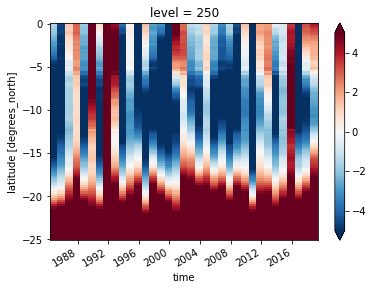

In [70]:
era_djf.mean('longitude').T.plot(vmin=-5, vmax=5, cmap='RdBu_r')

/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


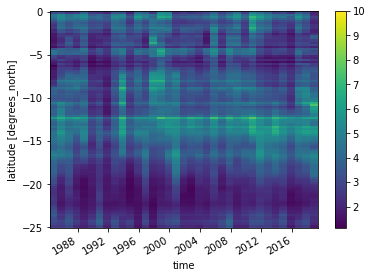

In [71]:
ch_djf.mean('longitude').T.plot(vmax=10, cmap='viridis')

/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


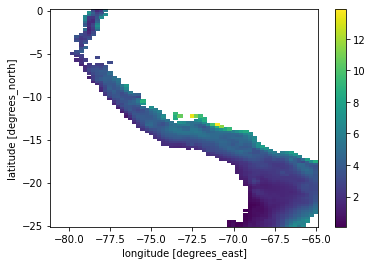

In [72]:
ch_djf.mean('time').plot()

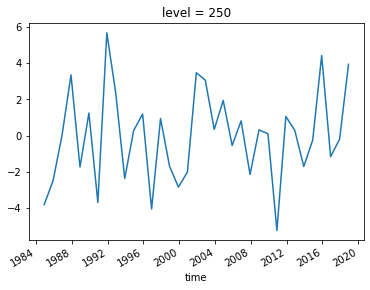

In [74]:
era_djf.mean('longitude').sel(latitude=slice(-18,-15)).mean('latitude').plot()

/home/ck/miniconda3/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


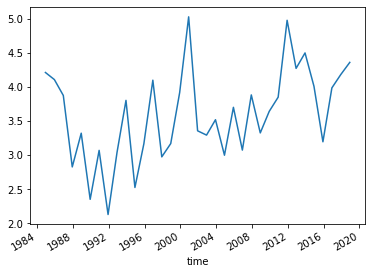

In [75]:
ch_djf.mean('longitude').sel(latitude=slice(-18,-15)).mean('latitude').plot()

In [76]:
era_djf.mean('longitude').sel(latitude=slice(-18,-15)).mean()

<xarray.DataArray ()>
array(-0.03460572)
Coordinates:
    level    int32 250

In [42]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [ ]:
regions = {
    'equatorial' : [(-5,0)],
    'transition' : [(-8,-5)],
    'central' : [(-12,-8)],
    'southern' : [(-18,-12)]}
h = 2000